# Model selection and hyperparameter tunning

In [1]:
import pandas as pd

from sklearn.model_selection import StratifiedKFold


from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier, Pool
import itertools
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier



import warnings
warnings.filterwarnings('ignore')

from utils import *

from sklearn.multiclass import OneVsRestClassifier


In [2]:
df = pd.read_csv("data/train_new_feats.csv")


In [3]:

target = [[f"target_{i}" for i in range(1, 9)] + ["Claim Injury Type"] + ["WCB Decision"] + ["Agreement Reached"] + ["Claim Injury Type_encoded"]]
target = [item for sublist in target for item in sublist]
target

binary_target = [f"target_{i}" for i in range(1, 9)]

original_target  = [col for col in target if col not in binary_target]

ordinal_target = ["Claim Injury Type_encoded"]


In [4]:

features = [feat for feat in df.columns if feat not in target]

features = [feat for feat in features if df[feat].dtype != "datetime64[ns]"]

num_feats = [feat for feat in features if df[feat].dtype != "object"]

cat_feats = [feat for feat in features if df[feat].dtype == "object"]
cat_feats_index = [features.index(feat) for feat in cat_feats]


In [ ]:


selected_features = [
    'Age at Injury',
    'Attorney/Representative',
    'IME-4 Count',
    'Accident Date_year',
    'Accident Date_assembly_gap_days',
    'C3-C2_gap_days',
    'C2_missing',
    'C3_missing',
    'C3_Accident_gap_weeks',
    'Hearing_C3 gap_months',
    'Hearing_C2 gap_months',
    'Days to Assembly',
    'Days to First Hearing',
    'Average Weekly Wage_log',
    'Carrier Name_encoded',
    'County of Injury_encoded',
    'Industry Code Description_encoded',
    'WCIO Cause of Injury Description_encoded',
    'WCIO Nature of Injury Description_encoded',
    'WCIO Part Of Body Description_encoded',
    'Zip Code_encoded',
    'County of Worker_encoded',
    'Carrier Name_freq',
    'County of Injury_freq',
    'District Name_freq',
    'Industry Code Description_freq',
    'WCIO Cause of Injury Description_freq',
    'WCIO Nature of Injury Description_freq',
    'WCIO Part Of Body Description_freq',
    'Zip Code_freq',
    'County of Worker_freq'
 ]


In [ ]:

naive_features = [feat.replace("_encoded", "") for feat in selected_features]
naive_features = [feat.replace(f"_freq", "") for feat in naive_features]
naive_features = set(naive_features)
naive_features = list(naive_features)

cat_feats = [feat for feat in naive_features if feat in cat_feats]

In [ ]:
log_reg_params = {'C': [1], "solver":["lbfgs"], "class_weight":[None, "balanced"]}
nb_params = {"var_smoothing": [1e-9, 0.1]}
#knn_params = {'weights' : ['uniform','distance'], "n_neighbors":[5, 7]}
rfc_params = {"max_depth": [6], "class_weight": ["balanced"]}
#gb_params = {"max_depth": [3, 9], "n_estimators": [100, 300], "learning_rate": [0.1, 0.01]}
#xgboost_params = {"max_depth": [6, 9], "learning_rate": [0.3, 0.03]}
#hbg_params = {"max_depth": [6, 9], "learning_rate": [0.1, 0.01], "max_iter":[100, 200], "class_weight":[None, "balanced"]}
catboost_params = {'iterations': [1000], 'depth':[6], 'boosting_type': ['Ordered'], "auto_class_weights": ["SqrtBalanced"], "loss_function": ["MultiClassOneVsAll"]} #"l2_leaf_reg":[4] # }
nn_params = {'hidden_layer_sizes': [(25, 8)], "learning_rate_init": [0.01]}
#svc_params = {"C": [1, 0.1], "class_weight": [None, "balanced"]}


models = [
    ('Logistic Regression', LogisticRegression(random_state=42), log_reg_params),
    ("NB", GaussianNB(), nb_params), # ele ajusta automaticamente the class priors as a parameter
    #("KNNC", KNeighborsClassifier(), knn_params),
    ("Random Forest", RandomForestClassifier(random_state=42), rfc_params),
    #("Gradient Boosting", GradientBoostingClassifier(random_state=42), gb_params),
    #("HGB", HistGradientBoostingClassifier(random_state=42), hbg_params),
    #("xgboost", XGBClassifier(random_state=42, verbose=0), xgboost_params),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=100), catboost_params),
    ("Neural Network", MLPClassifier(random_state=42, verbose=10), nn_params),
    #("SVC", SVC(random_state=42), svc_params),
]


In [7]:

n_splits = 3
stratified_kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

X = df[naive_features]
y = df[ordinal_target]

X.columns

y.value_counts(normalize=True)
models_params = []
for i, (train_index, val_index) in enumerate(stratified_kf.split(X, y), start=1):
    print(f"Starting CV_{i}/3 for {ordinal_target}...")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    #--------------- Target Ordinal Encoding 
        

    print(f"Ordinal encoding...")
    X_train_encoded = X_train.copy()
    X_val_encoded = X_val.copy()
    for cat in cat_feats:
        X_train_encoded, X_val_encoded, ordinal_mapping = target_guided_ordinal_encoding(X_train_encoded, X_val_encoded, cat, ordinal_target, y_train, 1)

    
    columns = X_train_encoded.columns

    
    # --------------- Frequency Encoding
    print(f"Frequency encoding...")
    for cat in cat_feats:
        X_train_encoded, X_val_encoded, freq_map = frequency_encoding(X_train_encoded, X_val_encoded, cat)

    
    X_train_encoded  = X_train_encoded[selected_features]
    X_val_encoded = X_val_encoded[selected_features]
    
    
    # --------------- Imputing missing values
    print(f"Impuiting missing values...")
    X_train_imputed, X_val_imputed = num_imputing(X_train_encoded, X_val_encoded)
        
    for clf_name, clf, param_grid in models:
        # -------------- Scaling and Normalizing for some models
        if clf_name in ["Logistic Regression", "KNNC", "Neural Network", "NB", "SVC"]:
            X_train_imputed, X_val_imputed = num_scaling(X_train_imputed, X_val_imputed)
        

        # -------------- Get the possible combinations of hyperparameters for each model
        print(f"Testing combinations for {clf_name}...")
        scores_dict = {}

        if param_grid:
            keys, values = zip(*param_grid.items())
            for combination in itertools.product(*values):
                params = dict(zip(keys, combination))
                if params:
                    if clf_name == "CatBoost":
                        clf = CatBoostClassifier(**params, verbose=10)
                    else:
                        clf.set_params(**params)
                    clf.fit(X_train_imputed, y_train)
                    params, train_score, val_score = model_predictions_global(X_train_imputed, y_train, X_val_imputed, y_val, clf, clf_name, ordinal_target, i, params)
                    scores_dict[(clf_name, tuple(params.items()))] = val_score
                models_params.append({
                    "clf_name": clf_name,
                    "CV":f"CV_{i}",
                    "params": params,
                    "train_score": train_score,
                    "validation_score": val_score})
                
                # ----------- OvRClassifier for the model
                if clf_name == "Random Forest":
                    clf.set_params(**params)
                    clf_ovr = OneVsRestClassifier(clf)
                    clf_ovr.fit(X_train_imputed, y_train)
                    params, train_score, val_score = model_predictions_global(X_train_imputed, y_train, X_val_imputed, y_val, clf_ovr, f"OVR_{clf_name}", ordinal_target, i, params)
                    scores_dict[(f"OVR_{clf_name}", tuple(params.items()))] = val_score
                    models_params.append({
                        "clf_name": f"OVR_{clf_name}",
                        "CV":f"CV_{i}",
                        "params": params,
                        "train_score": train_score,
                        "validation_score": val_score})
                    
        best_params, best_score = max(scores_dict.items(), key=lambda x: x[1])
        print(f"Best params for {clf_name}:")
        
        print("--------------------------------------------------")

    print("--------------------------------------------------")
    
    
    
    
    
    

Starting CV_1/3 for ['Claim Injury Type_encoded']...
Ordinal encoding...
Frequency encoding...
Impuiting missing values...
Testing combinations for Logistic Regression...
Logistic Regression...
Params: {'C': 1, 'solver': 'lbfgs', 'class_weight': None}
Train F1-score: 0.414
Thresholds: [np.float64(0.30222754508182975), np.float64(0.43695368769717763), np.float64(0.12450631621498295), np.float64(0.38939472874069364), np.float64(0.2957329241962443), np.float64(0.06675727049958108), np.float64(0.056719415102136864), np.float64(0.2358520836305238)]
Validation F1-score: 0.412
              precision    recall  f1-score   support

         0.0       0.62      0.44      0.52      4159
         1.0       0.87      0.92      0.89     97031
         2.0       0.25      0.29      0.27     22970
         3.0       0.72      0.65      0.68     49505
         4.0       0.57      0.47      0.52     16094
         5.0       0.12      0.11      0.12      1403
         6.0       0.00      0.00      0.00 

In [9]:
results = pd.DataFrame(models_params) 

mean_val_scores = results.groupby('clf_name')['validation_score'].mean().sort_values(ascending=False)

print(mean_val_scores)

clf_name
CatBoost               0.486894
Neural Network         0.446874
Random Forest          0.405191
Logistic Regression    0.395470
NB                     0.317412
OVR_Random Forest      0.313638
Name: validation_score, dtype: float64


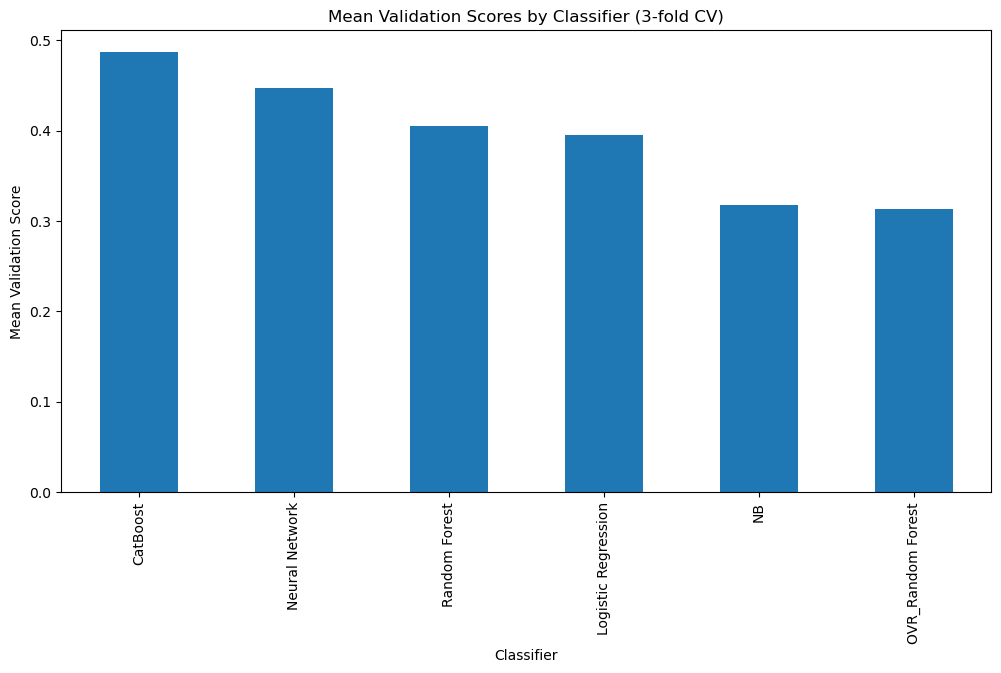

In [12]:
mean_val_scores.plot(kind='bar', figsize=(12, 6), title="Mean Validation Scores by Classifier (3-fold CV)")
plt.xlabel("Classifier")
plt.ylabel("Mean Validation Score")
plt.show()